# 0. Setup Paths

In [1]:
import pandas as pd
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import cv2 
import numpy as np

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

from object_detection.utils import label_map_util
import os
%matplotlib inline

In [2]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

# 7. Initialize

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-3')).expect_partial()

category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH + '\label_map.pbtxt')

In [11]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

def get_box(img_path, detections):
    img = cv2.imread(img_path)
    im_width, im_height, _ = img.shape
    [ymin, xmin, ymax, xmax] = detections['detection_boxes'][0]
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                              ymin * im_height, ymax * im_height)
    return (left, right, top, bottom)

def process_video(img_path, return_df=True, write_frames=False):
    cap = cv2.VideoCapture(img_path)
    fps = cap.get(cv2.CAP_PROP_FPS)   
    rows = []

    while True:
        ret, img = cap.read()    

        current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if ret == True:
            if current_frame % fps == 0:
                # detect 
                image_np = np.array(img)
                input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
                detections = detect_fn(input_tensor)
                num_detections = int(detections.pop('num_detections'))
                detections = {key: value[0, :num_detections].numpy()
                              for key, value in detections.items()}

                if return_df:                
                    # return as data frame
                    current_seconds = current_frame/fps
                    if sum(detections['detection_scores'][:5] > 0.8) > 0:
                        rows.append({
                            'seconds': current_seconds,
                            'detected': 1
                        })                    
                
                if write_frames:
                    # create bounding box 
                    detections['num_detections'] = num_detections
                    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
                    label_id_offset = 1
                    image_np_with_detections = image_np.copy()

                    # draw box 
                    viz_utils.visualize_boxes_and_labels_on_image_array(
                                image_np_with_detections,
                                detections['detection_boxes'],
                                detections['detection_classes']+label_id_offset,
                                detections['detection_scores'],
                                category_index,
                                use_normalized_coordinates=True,
                                max_boxes_to_draw=5,
                                min_score_thresh=.8,
                                agnostic_mode=False)

                    # output
                    if sum(detections['detection_scores'][:5] > 0.8) > 0:
                        file_name = "frames/" + img_path.split('.')[0] + '_f' + str(round(current_frame/fps)) + ".jpg"
                        cv2.imwrite(file_name, image_np_with_detections)
                        # cv2.imshow('video', image_np_with_detections)
                
                print('Processing: {} seconds, frame {}'.format(current_frame/fps, current_frame))
            if cv2.waitKey(25) == ord('q'):
                break
        else:
            break
            
    return pd.DataFrame(rows)

def process_realtime(cap):
    while True:
        ret, img = cap.read()    

        if ret == True:
            image_np = np.array(img)

            input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
            detections = detect_fn(input_tensor)

            num_detections = int(detections.pop('num_detections'))
            detections = {key: value[0, :num_detections].numpy()
                          for key, value in detections.items()}
            detections['num_detections'] = num_detections

            # detection_classes should be ints.
            detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

            label_id_offset = 1
            image_np_with_detections = image_np.copy()

            viz_utils.visualize_boxes_and_labels_on_image_array(
                        image_np_with_detections,
                        detections['detection_boxes'],
                        detections['detection_classes']+label_id_offset,
                        detections['detection_scores'],
                        category_index,
                        use_normalized_coordinates=True,
                        max_boxes_to_draw=5,
                        min_score_thresh=.8,
                        agnostic_mode=False)


            cv2.imshow('video', image_np_with_detections)
    #         current_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    #         print('{}: {}'.format(current_frame,current_frame/fps))
            if cv2.waitKey(25) == ord('q'):
                break
        else:
            break
            
def process_image(img_path):
    img = cv2.imread(img_path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()            

# Detect Image

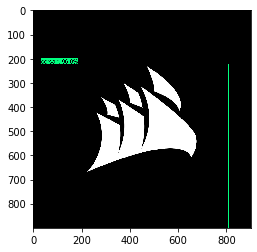

In [44]:
process_image(img_path)

# Process Real Time



In [5]:
cap = cv2.VideoCapture("1101763346_clip_s3009_d61.mp4")
process_realtime(cap)

In [6]:
cap.release()
cv2.destroyAllWindows()

# Process Video

In [14]:
# img_path = "1103313375_clip_s14476_d132-cut-1.mp4"
img_path = "1106871070_clip_s17118_d16.mp4"
df = process_video(img_path, return_df=True, write_frames=True)

Processing: 1.0 seconds, frame 60.0
Processing: 2.0 seconds, frame 120.0
Processing: 3.0 seconds, frame 180.0
Processing: 4.0 seconds, frame 240.0
Processing: 5.0 seconds, frame 300.0
Processing: 6.0 seconds, frame 360.0
Processing: 7.0 seconds, frame 420.0
Processing: 8.0 seconds, frame 480.0
Processing: 9.0 seconds, frame 540.0
Processing: 10.0 seconds, frame 600.0
Processing: 11.0 seconds, frame 660.0
Processing: 12.0 seconds, frame 720.0
Processing: 13.0 seconds, frame 780.0
Processing: 14.0 seconds, frame 840.0
Processing: 15.0 seconds, frame 900.0
Processing: 16.0 seconds, frame 960.0


In [13]:
df

""


In [18]:
df = pd.read_csv('1102239417_s0_d3600.csv').drop(columns=['Unnamed: 0'])

In [24]:
df2 = pd.DataFrame([x + 1 for x in range(3600)], columns=['seconds'])

In [28]:
df = df2.merge(df, how='left', on='seconds')

In [31]:
df['detected'] = df['detected'].fillna(0)

In [33]:
df.to_csv('1102239417_s0_d3600_answer_sheet.csv')

# Measure Accuracy

In [39]:
from sklearn.metrics import classification_report

In [55]:
df = pd.read_csv('1102239417_s0_d3600_answer_sheet.csv').drop(columns=['Unnamed: 0'])
# df = df.iloc[:1600]
df = df.fillna(0)

In [57]:
print(classification_report(df['labeled'], df['detected']))

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      2866
         1.0       0.64      1.00      0.78       760

    accuracy                           0.88      3626
   macro avg       0.82      0.93      0.85      3626
weighted avg       0.92      0.88      0.89      3626



In [58]:
df = df[df['first_score'] > .9]

In [59]:
print(classification_report(df['labeled'], df['detected']))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        27
         1.0       0.96      1.00      0.98       708

    accuracy                           0.96       735
   macro avg       0.48      0.50      0.49       735
weighted avg       0.93      0.96      0.95       735



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
